# FermiPy

Fermipy is a python package that facilitates analysis of data from the Large Area Telescope (LAT) with the Fermi Science Tools.

The Fermipy package is built on the pyLikelihood interface of the Fermi Science Tools and provides a set of high-level tools for performing common analysis tasks:

* Data and model preparation with the gt-tools (gtselect, gtmktime, etc.).
* Extracting a spectral energy distribution (SED) of a source.
* Generating TS and residual maps for a region of interest.
* Finding new source candidates.
* Localizing a source or fitting its spatial extension.
* Fermipy uses a configuration-file driven workflow in which the analysis parameters (data selection, IRFs, and ROI model) are defined in a YAML configuration file. Analysis is executed through a python script that calls the methods of GTAnalysis to perform different analysis operations.

For instructions on installing Fermipy see the [Installation](http://fermipy.readthedocs.io/en/latest/install.html#install) page. For a short introduction to using Fermipy see the [Quickstart Guide](http://fermipy.readthedocs.io/en/latest/quickstart.html#quickstart).

## Community Driven Project

All of the code is on [GitHub](https://github.com/fermiPy).  If you have questions about using Fermipy please open a [GitHub Issue](https://github.com/fermiPy/fermipy/issues) or email the [Fermipy developers](fermipy.developers%40gmail.com).

I encourage you to look at the code and improve it and give back to the project

## Our Analysis

We are going to redo the analysis we did yesterday with Fermipy.  I have precomputed many of the files so it shouldn't take that long.  Please download the data files and put them in your working directory.

Download link: https://drive.google.com/file/d/1cn13jOLNmbKOkhN_5Zq04wo3xrmclOGT/view?usp=sharing

### import some useful packages and utilities

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [4]:
ls

config.yaml           data.tgz          Likelihood With fermiPy.ipynb
Curvature Test.ipynb  Lightcurve.ipynb


In [5]:
!tar zxvf data.tgz

data/
data/bexpmap_00.fits
data/bexpmap_01.fits
data/bexpmap_02.fits
data/bexpmap_03.fits
data/bexpmap_roi_00.fits
data/bexpmap_roi_01.fits
data/bexpmap_roi_02.fits
data/bexpmap_roi_03.fits
data/ccube_00.fits
data/ccube_01.fits
data/ccube_02.fits
data/ccube_03.fits
data/ccube.fits
data/evfile_00.txt
data/evfile_01.txt
data/evfile_02.txt
data/evfile_03.txt
data/ft1_00.fits
data/ft1_01.fits
data/ft1_02.fits
data/ft1_03.fits
data/ltcube_00.fits
data/ltcube_01.fits
data/ltcube_02.fits
data/ltcube_03.fits
data/PH00.fits
data/PH01.fits
data/SC00.fits
data/srcmap_00.fits
data/srcmap_01.fits
data/srcmap_02.fits
data/srcmap_03.fits
data/srcmdl_00.xml
data/srcmdl_01.xml
data/srcmdl_02.xml
data/srcmdl_03.xml
data/events.txt


## Config File

The first step is to compose a configuration file that defines the data selection and analysis parameters. Complete documentation on the configuration file and available options is given in the [Configuration](http://fermipy.readthedocs.io/en/latest/config.html#config) page. fermiPy uses the [YAML](http://yaml.org/) format for its configuration files.

Our file is called ```config.yaml``` and it looks like this:

```
data:
  evfile : events.txt
  scfile : SC00.fits

binning:
  roiwidth   : 15.0
  binsz      : 0.1
  binsperdec : 8

selection :
  emin : 100
  emax : 100000
  zmax    : 100
  evclass : 128
  evtype  : 3
  tmin    : 239557417
  tmax    : 255398400
  filter  : null
  target : '3C 279'

gtlike:
  edisp : True
  irfs : 'P8R2_SOURCE_V6'
  edisp_disable : ['isodiff','galdiff']

model:
  src_roiwidth : 20.0
  galdiff  : '/data/fermi-summer-school/data/gll_iem_v06.fits'
  isodiff  : 'iso_P8R2_SOURCE_V6_v06.txt'
  catalogs : ['3FGL']

components:
  - { selection : { evtype : 4  } } # PSF0
  - { selection : { evtype : 8  } } # PSF1
  - { selection : { evtype : 16 } } # PSF2
  - { selection : { evtype : 32 } } # PSF3

fileio:
   outdir : data
```

## Import the package

In [6]:
from fermipy.gtanalysis import GTAnalysis

## setup the object and load in the config file
We are reading in the configuration file here and configuring the analysis


In [8]:
gta = GTAnalysis('config.yaml',logging={'verbosity' : 3})

2018-05-31 16:58:09 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 0.16.0 
ScienceTools version 


### The log file

Everything that FermiPy does is saved in a log file so that you can go back and see what you've done.

In [9]:
!tail -n50 data/fermipy.log

  galdiff:
  - /data/fermi-summer-school/data/gll_iem_v06.fits
  isodiff:
  - iso_P8R2_SOURCE_V6_v06.txt
  limbdiff: []
  merge_sources: true
  sources: []
  src_radius: null
  src_radius_roi: null
  src_roiwidth: 20.0
name: '03'
selection:
  convtype: null
  dec: null
  emax: 100000.0
  emin: 100.0
  evclass: 128
  evtype: 32
  filter: null
  glat: null
  glon: null
  logemax: !!python/object/apply:numpy.core.multiarray.scalar
  - &id001 !!python/object/apply:numpy.dtype
    args:
    - f8
    - 0
    - 1
    state: !!python/tuple
    - 3
    - <
    - null
    - null
    - null
    - -1
    - -1
    - 0
  - "\0\0\0\0\0\0\x14@"
  logemin: !!python/object/apply:numpy.core.multiarray.scalar
  - *id001
  - "\0\0\0\0\0\0\0@"
  phasemax: null
  phasemin: null
  ra: null
  radius: 11.106601717798213
  roicut: 'no'
  target: 3C 279
  tmax: 255398400
  tmin: 239557417
  zmax: 100.0



## Run the setup step

This will load in all of the precomputed files.  If they didn't exist it would create them.  It also sets up the likelihood method so that we can do a fit.  

*Basically this does all of the steps we did yesterday in one step.  It also handles all of the different event types that we wanted.*

The ```setup()``` method performs the data preparation and response calculations needed for the analysis (selecting the data, creating counts and exposure maps, etc.). Depending on the data selection and binning of the analysis this will often be the slowest step in the analysis sequence. The output of ```setup()``` is cached in the analysis working directory so subsequent calls to ```setup()``` will run much faster.

In [10]:
gta.setup()

2018-05-31 16:58:26 INFO    GTAnalysis.setup(): Running setup.
2018-05-31 16:58:26 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2018-05-31 16:58:26 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2018-05-31 16:58:26 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2018-05-31 16:58:27 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
2018-05-31 16:58:27 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2018-05-31 16:58:27 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2018-05-31 16:58:27 INFO    GTBinnedAnalysis.setup(): Running setup for component 01
2018-05-31 16:58:27 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2018-05-31 16:58:27 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2018-05-31 16:58:28 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
2018-05-31 16:58:28 INFO   

## Optimize the ROI

This will loop over all model components in the ROI and fit their normalization and spectral shape parameters. This method also computes the TS of all sources which can be useful for identifying weak sources that could be fixed or removed from the model.

In [11]:
opt1 = gta.optimize()

2018-05-31 17:02:36 INFO    GTAnalysis.optimize(): Starting
2018-05-31 17:03:32 INFO    GTAnalysis.optimize(): Finished
2018-05-31 17:03:32 INFO    GTAnalysis.optimize(): LogLike: -146704.390818 Delta-LogLike: 964.893911
2018-05-31 17:03:32 INFO    GTAnalysis.optimize(): Execution time: 55.79 s


We saved the output of this step into a variable.  It's just a dictionary.

In [12]:
opt1

{'config': {'max_free_sources': 5,
  'npred_frac': 0.95,
  'npred_threshold': 1.0,
  'optimizer': {'init_lambda': 0.0001,
   'max_iter': 100,
   'min_fit_quality': 2,
   'optimizer': 'MINUIT',
   'retries': 3,
   'tol': 0.001,
   'verbosity': 0},
  'shape_ts_threshold': 25.0,
  'skip': []},
 'dloglike': 964.8939113062224,
 'loglike0': -147669.28472901048,
 'loglike1': -146704.39081770426}

We can also look at the results via the ```print_roi()``` function:

In [13]:
gta.print_roi()

2018-05-31 17:04:04 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
3FGL J1256.1-0547   PointSource    LogParabola       0.000  16417.10      7956.1
3FGL J1249.5-0546   PointSource    PowerLaw          1.651      5.57       106.8
3FGL J1304.8-0338   PointSource    PowerLaw          3.041      1.10        32.8
3FGL J1250.2-0233   PointSource    PowerLaw          3.546     -0.00         0.0
3FGL J1251.0-0203   PointSource    PowerLaw          3.946      1.48        22.1
3FGL J1312.8-0424   PointSource    PowerLaw          4.388      0.76        22.3
3FGL J1243.9-0217   PointSource    PowerLaw          4.652     14.24        71.1
3FGL J1315.7-0732   PointSource    PowerLaw          5.180     19.66        69.8
3FGL J1234.7-0437   PointSource    PowerLaw          5.449      1.64         8.2
3FGL J1256.3-1146   PointSource    PowerLaw          5.9

Note that there are many sources that are not really detected.  This uses the full 3FGL which was developed using 4 years of data and we're looking at 6 months.  Let's just get rid of any sources with a TS < 1.  It'll make the model simpler.

In [14]:
gta.delete_sources?

In [15]:
deleted_sources = gta.delete_sources(minmax_ts=[-1,3])

2018-05-31 17:04:15 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1304.8-0338
2018-05-31 17:04:15 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1250.2-0233
2018-05-31 17:04:16 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1251.0-0203
2018-05-31 17:04:16 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1312.8-0424
2018-05-31 17:04:16 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1234.7-0437
2018-05-31 17:04:16 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1228.4-0317
2018-05-31 17:04:16 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1250.5+0217
2018-05-31 17:04:16 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1329.1-0536
2018-05-31 17:04:16 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1253.7+0327
2018-05-31 17:04:16 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1219.7-0314
2018-05-31 17:04:16 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J1241.6-1456
2018-05-31

In [16]:
gta.print_roi()

2018-05-31 17:04:19 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
3FGL J1256.1-0547   PointSource    LogParabola       0.000  16417.10      7956.1
3FGL J1249.5-0546   PointSource    PowerLaw          1.651      5.57       106.8
3FGL J1243.9-0217   PointSource    PowerLaw          4.652     14.24        71.1
3FGL J1315.7-0732   PointSource    PowerLaw          5.180     19.66        69.8
3FGL J1256.3-1146   PointSource    PowerLaw          5.990     31.21        85.5
3FGL J1233.7-0145   PointSource    PowerLaw          6.897     24.54       126.8
3FGL J1310.2-1159   PointSource    PowerLaw          7.106      9.14        23.1
3FGL J1311.0+0036   PointSource    PowerLaw          7.409     15.45        17.5
3FGL J1239.1-1158   PointSource    PowerLaw          7.472      7.17       113.1
3FGL J1322.8-0938   PointSource    PowerLaw          7.6

Now we're going to free sources close to the center and do a more detailed fit of the innner region and I'm also freeing up the high TS sources.  Note that I'm leaving their spectral shapes fixed.

In [17]:
# Free Normalization of all Sources within 5 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free sources with TS > 10
gta.free_sources(minmax_ts=[10,None],pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta.free_source('galdiff')
gta.free_source('isodiff')

2018-05-31 17:04:23 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1256.1-0547     : ['norm']
2018-05-31 17:04:23 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1249.5-0546     : ['Prefactor']
2018-05-31 17:04:23 INFO    GTAnalysis.free_source(): Freeing parameters for isodiff               : ['Normalization']
2018-05-31 17:04:23 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Prefactor']
2018-05-31 17:04:23 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1243.9-0217     : ['Prefactor']
2018-05-31 17:04:23 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1315.7-0732     : ['Prefactor']
2018-05-31 17:04:23 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1256.3-1146     : ['Prefactor']
2018-05-31 17:04:23 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1233.7-0145     : ['Prefactor']
2018-05-31 17:04:23 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL

Now we'll do the fit and save the results in the ```fit1``` varialble.

In [18]:
fit1 = gta.fit()

2018-05-31 17:04:25 INFO    GTAnalysis.fit(): Starting fit.
2018-05-31 17:05:01 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2018-05-31 17:05:01 INFO    GTAnalysis.fit(): LogLike:  -146707.938 DeltaLogLike:        4.518 


In [19]:
gta.print_roi()

2018-05-31 17:06:12 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
3FGL J1256.1-0547   PointSource    LogParabola       0.000  14212.61      7906.6
3FGL J1249.5-0546   PointSource    PowerLaw          1.651      8.28       144.5
3FGL J1243.9-0217   PointSource    PowerLaw          4.652     15.73        78.1
3FGL J1315.7-0732   PointSource    PowerLaw          5.180     19.74        69.4
3FGL J1256.3-1146   PointSource    PowerLaw          5.990     29.36        80.3
3FGL J1233.7-0145   PointSource    PowerLaw          6.897     28.66       143.2
3FGL J1310.2-1159   PointSource    PowerLaw          7.106      9.14        23.1
3FGL J1311.0+0036   PointSource    PowerLaw          7.409     15.94        18.1
3FGL J1239.1-1158   PointSource    PowerLaw          7.472      7.17       113.1
3FGL J1322.8-0938   PointSource    PowerLaw          7.6

In [20]:
print(gta.roi['3FGL J1256.1-0547'])

Name           : 3FGL J1256.1-0547
Associations   : ['3FGL J1256.1-0547', '3C 279', '1FHL J1256.1-0547', '2FGL J1256.1-0547', '1AGL J1256-0549', '3EG J1255-0549']
RA/DEC         :    194.041/    -5.791
GLON/GLAT      :    305.094/    57.061
TS             : 14212.61
Npred          : 7906.57
Flux           : 6.735e-07 +/- 1.08e-08
EnergyFlux     : 0.0002648 +/- 4.24e-06
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
norm           :   5.81e-10 +/-  9.298e-12
alpha          :      2.141 +/-        nan
beta           :    0.06165 +/-        nan
Eb             :        342 +/-        nan


You can save the results (and reload them later which is really nice).  Note that it saves plots in a fits file and the results of the fits in a numpy file).

In [21]:
gta.write_roi('fit1',make_plots=True)

2018-05-31 17:06:16 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1_00.xml...
2018-05-31 17:06:16 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1_01.xml...
2018-05-31 17:06:16 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1_02.xml...
2018-05-31 17:06:16 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1_03.xml...
2018-05-31 17:06:16 INFO    GTAnalysis.write_fits(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1.fits...
2018-05-31 17:06:53 INFO    GTAnalysis.write_roi(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1.npy...


In [22]:
ls data/*.png

data/fit1_counts_map_2.000_5.000.png        data/fit1_counts_spectrum.png
data/fit1_counts_map_xproj_2.000_5.000.png  data/fit1_model_map_2.000_5.000.png
data/fit1_counts_map_yproj_2.000_5.000.png


![fit1_counts_spectrum.png](data/fit1_counts_spectrum.png)
![fit1_counts_map_2.000_5.000.png](data/fit1_counts_map_2.000_5.000.png)
![fit1_model_map_2.000_5.000.png](data/fit1_model_map_2.000_5.000.png)
![fit1_counts_map_xproj_2.000_5.000.png](data/fit1_counts_map_xproj_2.000_5.000.png)  
![fit1_counts_map_yproj_2.000_5.000.png](data/fit1_counts_map_yproj_2.000_5.000.png)

Before we go on, let's fix all of the sources.

In [23]:
fixed_sources = gta.free_sources(free=False)

2018-05-31 17:08:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1256.1-0547     : ['norm']
2018-05-31 17:08:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1249.5-0546     : ['Prefactor']
2018-05-31 17:08:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1243.9-0217     : ['Prefactor']
2018-05-31 17:08:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1315.7-0732     : ['Prefactor']
2018-05-31 17:08:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1256.3-1146     : ['Prefactor']
2018-05-31 17:08:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1233.7-0145     : ['Prefactor']
2018-05-31 17:08:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1311.0+0036     : ['Prefactor']
2018-05-31 17:08:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1322.8-0938     : ['Prefactor']
2018-05-31 17:08:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1312.7+0051

### Residual Maps

We can create a residual map of our region to see if we've modeled everything right.  A residual map is just the left over counts after we've subtracted all of our modeled sources from the ROI.

In [24]:
resid = gta.residmap('3C 279',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2018-05-31 17:08:09 INFO    GTAnalysis.residmap(): Generating residual maps
2018-05-31 17:08:09 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2018-05-31 17:08:24 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2018-05-31 17:08:28 INFO    GTAnalysis.residmap(): Finished residual maps
2018-05-31 17:08:28 INFO    GTAnalysis.residmap(): Execution time: 18.48 s


There's a handy helper function that makes pretty skymaps.

In [25]:
from fermipy.plotting import ROIPlotter

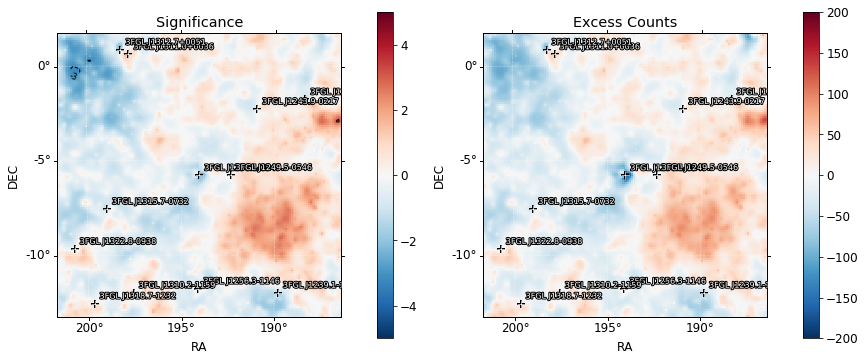

In [26]:
o = resid
fig = plt.figure(figsize=(14,6))
ROIPlotter(o['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5,7,9],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(o['excess'],roi=gta.roi).plot(vmin=-200,vmax=200,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess Counts')
plt.show()

We can make a residual map excluding a source.

In [27]:
resid_noj1322 = gta.residmap('3C 279 noj1322',
                model={'SpatialModel' : 'PointSource', 'Index' : 2.0},
                exclude=['3FGL J1322.8-0938'])

2018-05-31 17:08:37 INFO    GTAnalysis.residmap(): Generating residual maps
2018-05-31 17:08:37 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2018-05-31 17:08:52 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2018-05-31 17:08:57 INFO    GTAnalysis.residmap(): Finished residual maps
2018-05-31 17:08:57 INFO    GTAnalysis.residmap(): Execution time: 19.55 s


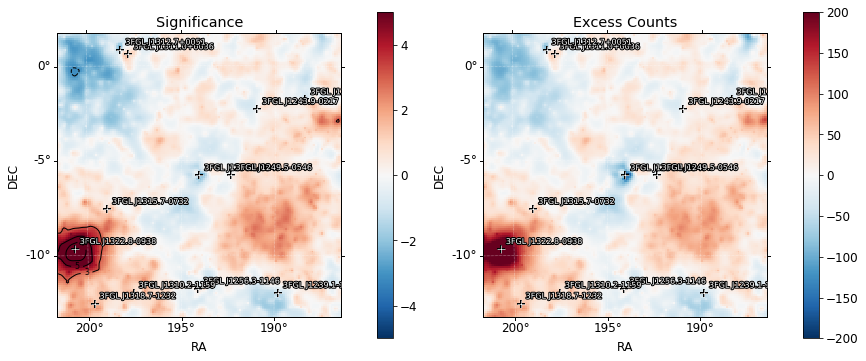

In [28]:
o = resid_noj1322
fig = plt.figure(figsize=(14,6))
ROIPlotter(o['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5,7,9],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(o['excess'],roi=gta.roi).plot(vmin=-200,vmax=200,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess Counts')
plt.show()

## You can also make a TS map 

This is a map that puts a tentative source at every location and calculates the likelihood of it existing.

In [29]:
tsmap = gta.tsmap('3C 279',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2018-05-31 17:09:11 INFO    GTAnalysis.tsmap(): Generating TS map
2018-05-31 17:10:04 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-05-31 17:12:12 INFO    GTAnalysis.tsmap(): Finished TS map
2018-05-31 17:12:12 INFO    GTAnalysis.tsmap(): Execution time: 180.84 s


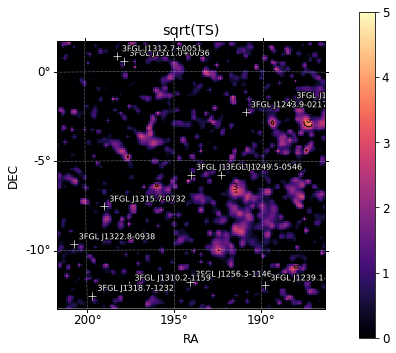

In [30]:
o = tsmap

fig = plt.figure(figsize=(6,6))
ROIPlotter(o['sqrt_ts'],roi=gta.roi).plot(vmin=0,vmax=5,levels=[3,5,7,9],subplot=111,cmap='magma')
plt.gca().set_title('sqrt(TS)')
plt.show()

In [31]:
tsmap_noj1322 = gta.tsmap('3C 279 noj1322',
                          model={'SpatialModel' : 'PointSource', 'Index' : 2.0},
                         exclude=['3FGL J1322.8-0938'])

2018-05-31 17:12:58 INFO    GTAnalysis.tsmap(): Generating TS map
2018-05-31 17:13:51 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-05-31 17:16:04 INFO    GTAnalysis.tsmap(): Finished TS map
2018-05-31 17:16:04 INFO    GTAnalysis.tsmap(): Execution time: 185.29 s


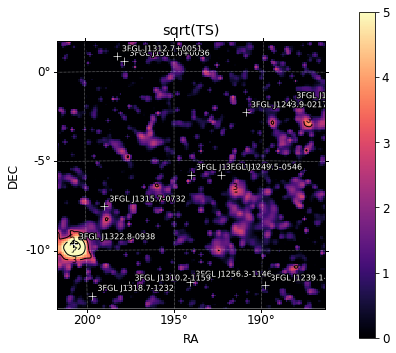

In [32]:
o = tsmap_noj1322

fig = plt.figure(figsize=(6,6))
ROIPlotter(o['sqrt_ts'],roi=gta.roi).plot(vmin=0,vmax=5,levels=[3,5,7,9],subplot=111,cmap='magma')
plt.gca().set_title('sqrt(TS)')
plt.show()

You can see what the diffuse emission looks like:

In [33]:
resid_nogal = gta.residmap('3C 279 nogal',
                model={'SpatialModel' : 'PointSource', 'Index' : 2.0},
                exclude=['galdiff'])

2018-05-31 17:16:57 INFO    GTAnalysis.residmap(): Generating residual maps
2018-05-31 17:16:57 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2018-05-31 17:17:11 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2018-05-31 17:17:15 INFO    GTAnalysis.residmap(): Finished residual maps
2018-05-31 17:17:15 INFO    GTAnalysis.residmap(): Execution time: 18.24 s


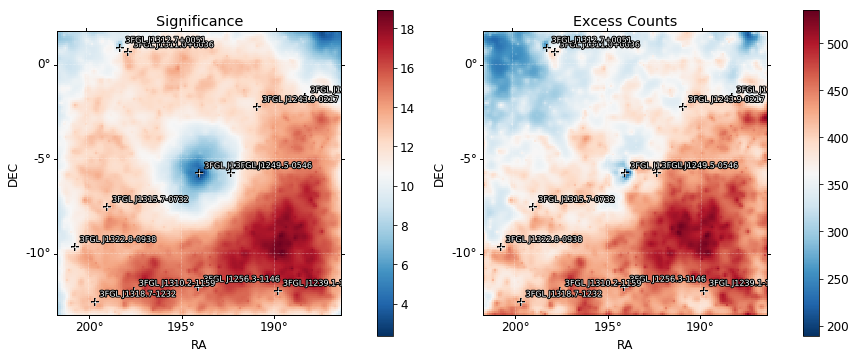

In [34]:
o = resid_nogal
fig = plt.figure(figsize=(14,6))
ROIPlotter(o['sigma'],roi=gta.roi).plot(subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(o['excess'],roi=gta.roi).plot(subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess Counts')
plt.show()

## Make an SED

There are many advanced functions like SEDs and lightcurves (see the documentation).  We'll make and SED.

In [35]:
sed = gta.sed('3C 279')

2018-05-31 17:17:21 INFO    GTAnalysis.sed(): Computing SED for 3FGL J1256.1-0547
2018-05-31 17:17:22 INFO    GTAnalysis._make_sed(): Fitting SED
2018-05-31 17:17:22 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1256.1-0547     : ['norm']
/home/astrosoft/sciencetools/x86_64-unknown-linux-gnu-libc2.12/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:226: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2018-05-31 17:17:33 INFO    GTAnalysis.sed(): Finished SED
2018-05-31 17:17:33 INFO    GTAnalysis.sed(): Execution time: 11.63 s


In [36]:
source = gta.roi.get_source_by_name('3FGL J1256.1-0547')

In [37]:
E = np.array(source['model_flux']['energies'])
dnde = np.array(source['model_flux']['dnde'])
dnde_hi = np.array(source['model_flux']['dnde_hi'])
dnde_lo = np.array(source['model_flux']['dnde_lo'])

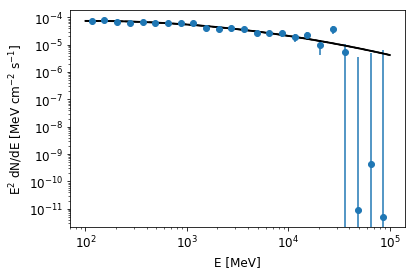

In [38]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(np.array(sed['e_ctr']),
             sed['e2dnde'], 
             yerr=sed['e2dnde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

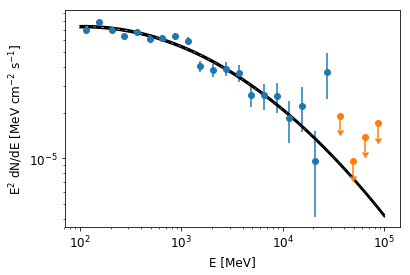

In [39]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(sed['e_ctr'][:-4],
             sed['e2dnde'][:-4], 
             yerr=sed['e2dnde_err'][:-4], fmt ='o')
plt.errorbar(np.array(sed['e_ctr'][-4:]),
         sed['e2dnde_ul95'][-4:], yerr=0.2*sed['e2dnde_ul95'][-4:], 
             fmt='o', uplims=True)
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

In [40]:
gta.write_roi('fit2_sed',make_plots=True)

2018-05-31 17:18:56 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed_00.xml...
2018-05-31 17:18:56 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed_01.xml...
2018-05-31 17:18:56 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed_02.xml...
2018-05-31 17:18:56 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed_03.xml...
2018-05-31 17:18:56 INFO    GTAnalysis.write_fits(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed.fits...
2018-05-31 17:19:34 INFO    GTAnalysis.write_roi(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed.npy...
